In [ ]:
pip install pyspark

In [ ]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Fire DF').getOrCreate()

In [ ]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
df = spark.read.csv('/content/sf-fire-calls.csv', header=True, inferSchema=True)
df.show()
df.printSchema()

+----------+------+--------------+----------------+----------+----------+--------------------+----------------+--------------------+----+-------+---------+-----------+----+----------------+--------+-------------+-------+-------------+---------+--------------+--------------------------+----------------------+------------------+--------------------+--------------------+-------------+---------+
|CallNumber|UnitID|IncidentNumber|        CallType|  CallDate| WatchDate|CallFinalDisposition|   AvailableDtTm|             Address|City|Zipcode|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumAlarms|      UnitType|UnitSequenceInCallDispatch|FirePreventionDistrict|SupervisorDistrict|        Neighborhood|            Location|        RowID|    Delay|
+----------+------+--------------+----------------+----------+----------+--------------------+----------------+--------------------+----+-------+---------+-----------+----+----------------+--------+------------

In [ ]:
df1 = df.select('CallType','CallDate','City','Zipcode','Neighborhood','Delay')
#df1.show()

In [ ]:
#add a new column
df2 = df1.withColumn('Date',to_date(col('CallDate'),'MM/dd/yyyy')).drop('CallDate')
#df2.show()

In [ ]:
df3 = df2.withColumn('Year',year(col('Date')))\
.withColumn('Week',weekofyear(col('Date')))\
.withColumn('Month',month(col('Date')))\

#df3.show()

In [ ]:
def mapseason(data):
  # Check if data is not None before comparison
  if data is not None:
    if 2 < data < 6:
      return 'Spring'
    elif 5 < data < 9:
      return 'Summer'
    elif 8 < data < 12:
      return 'Autumn'
    else:
      return 'Winter'
  # Handle None values by returning a default value or raising an exception
  else:
    return 'Unknown'  # or raise ValueError('Month value cannot be None')

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

seasonDF = udf(mapseason, StringType())
clean_df = df3.withColumn('Season',seasonDF(col('Month')))
clean_df.show()

+----------------+----+-------+--------------------+---------+----+----+----+-----+-------+
|        CallType|City|Zipcode|        Neighborhood|    Delay|Date|Year|Week|Month| Season|
+----------------+----+-------+--------------------+---------+----+----+----+-----+-------+
|  Structure Fire|  SF|  94109|     Pacific Heights|     2.95|NULL|NULL|NULL| NULL|Unknown|
|Medical Incident|  SF|  94124|Bayview Hunters P...|      4.7|NULL|NULL|NULL| NULL|Unknown|
|Medical Incident|  SF|  94102|          Tenderloin|2.4333334|NULL|NULL|NULL| NULL|Unknown|
|    Vehicle Fire|  SF|  94110|      Bernal Heights|      1.5|NULL|NULL|NULL| NULL|Unknown|
|          Alarms|  SF|  94109|    Western Addition|3.4833333|NULL|NULL|NULL| NULL|Unknown|
|  Structure Fire|  SF|  94105|Financial Distric...|     1.75|NULL|NULL|NULL| NULL|Unknown|
|          Alarms|  SF|  94112|Oceanview/Merced/...|2.7166667|NULL|NULL|NULL| NULL|Unknown|
|          Alarms|  SF|  94102|          Tenderloin|1.7833333|NULL|NULL|NULL| NU

1)Get yearly count of fire calls

In [ ]:


yearly_call_count = clean_df.groupBy("Year").count()
yearly_call_count.show()


+----+-----+
|Year|count|
+----+-----+
|2003| 5020|
|2018| 5966|
|2015| 6844|
|2006| 4851|
|2013| 6075|
|NULL|70404|
|2014| 6460|
|2012| 5745|
|2009| 5261|
|2016| 6995|
|2005| 5020|
|2010| 5566|
|2011| 5764|
|2008| 5343|
|2017| 7189|
|2002| 4863|
|2007| 4854|
|2004| 4976|
|2001| 4618|
|2000| 3482|
+----+-----+



2)What were all the different types of fire calls in 2018?

In [ ]:

fire_calls_2018 = clean_df.filter(clean_df.Year == 2018)


distinct_call_types_2018 = fire_calls_2018.select('CallType').distinct()


distinct_call_types_2018.show(truncate=False)

+-------------------------------+
|CallType                       |
+-------------------------------+
|Elevator / Escalator Rescue    |
|Alarms                         |
|Odor (Strange / Unknown)       |
|Citizen Assist / Service Call  |
|HazMat                         |
|Vehicle Fire                   |
|Other                          |
|Outside Fire                   |
|Traffic Collision              |
|Gas Leak (Natural and LP Gases)|
|Water Rescue                   |
|Electrical Hazard              |
|Structure Fire                 |
|Medical Incident               |
|Fuel Spill                     |
|Smoke Investigation (Outside)  |
|Train / Rail Incident          |
|Explosion                      |
|Suspicious Package             |
+-------------------------------+



3)Which week in the year in 2018 had the most fire calls?

In [ ]:


from pyspark.sql.functions import count


fire_calls_2018 = clean_df.filter(clean_df.Year == 2018)


weekly_call_counts_2018 = fire_calls_2018.groupBy("Week").agg(count("*").alias("CallCount"))

week_with_most_calls = weekly_call_counts_2018.orderBy(col("CallCount").desc()).first()

print("Week with the most fire calls in 2018:")
print(week_with_most_calls)


Week with the most fire calls in 2018:
Row(Week=43, CallCount=250)


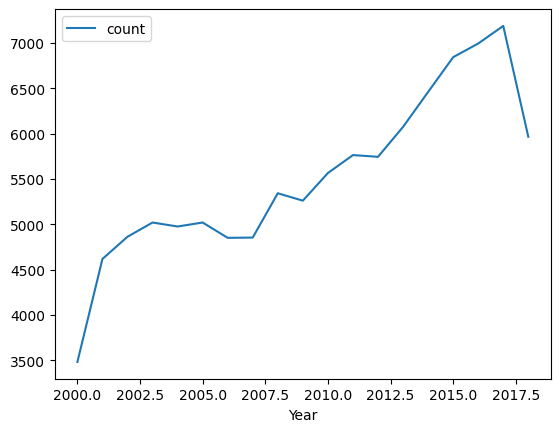

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
panda_df = clean_df.select('Year')\
.groupBy('Year')\
.count()\
.orderBy('Year', ascending = True)\
.toPandas()

panda_df.plot.line(x='Year', y='count')
plt.show()

4)Get monthly count of fire calls based on year

In [ ]:


monthly_counts = clean_df.groupBy('Year', 'Month').agg(count('*').alias('CallCount')).orderBy('Year', 'Month')
monthly_counts.show()


+----+-----+---------+
|Year|Month|CallCount|
+----+-----+---------+
|NULL| NULL|    70404|
|2000|    4|      333|
|2000|    5|      454|
|2000|    6|      360|
|2000|    7|      391|
|2000|    8|      414|
|2000|    9|      383|
|2000|   10|      390|
|2000|   11|      347|
|2000|   12|      410|
|2001|    1|      361|
|2001|    2|      344|
|2001|    3|      456|
|2001|    4|      380|
|2001|    5|      409|
|2001|    6|      391|
|2001|    7|      407|
|2001|    8|      386|
|2001|    9|      334|
|2001|   10|      420|
+----+-----+---------+
only showing top 20 rows



In [ ]:
clean_df.createOrReplaceTempView('Fire')
spark.sql('Select Year from Fire where Delay > 520').show()

+----+
|Year|
+----+
|2003|
|NULL|
|2015|
|NULL|
|NULL|
|2007|
|2004|
|NULL|
|2000|
+----+



5)Give monthly report of fire call types for selected year

In [ ]:


year_to_analyze = 2018


df_selected_year = clean_df.filter(clean_df.Year == year_to_analyze)


monthly_call_type_counts = df_selected_year.groupBy('Month', 'CallType').agg(count('*').alias('CallCount'))

monthly_call_type_counts = monthly_call_type_counts.orderBy('Month', 'CallType')


monthly_call_type_counts.show(truncate=False)


+-----+-------------------------------+---------+
|Month|CallType                       |CallCount|
+-----+-------------------------------+---------+
|1    |Alarms                         |72       |
|1    |Citizen Assist / Service Call  |8        |
|1    |Electrical Hazard              |2        |
|1    |Elevator / Escalator Rescue    |3        |
|1    |Fuel Spill                     |1        |
|1    |Gas Leak (Natural and LP Gases)|4        |
|1    |HazMat                         |1        |
|1    |Medical Incident               |408      |
|1    |Odor (Strange / Unknown)       |2        |
|1    |Other                          |2        |
|1    |Outside Fire                   |4        |
|1    |Smoke Investigation (Outside)  |2        |
|1    |Structure Fire                 |52       |
|1    |Traffic Collision              |25       |
|1    |Train / Rail Incident          |2        |
|1    |Vehicle Fire                   |1        |
|1    |Water Rescue                   |4        |


6)Give top five fire call types for every season of selected year (seasons are like Spring, summer, fall winter etc).

In [ ]:


year_to_analyze = 2018  # Replace with the desired year

# Filter the DataFrame for the selected year
df_selected_year = clean_df.filter(clean_df.Year == year_to_analyze)

# Group by season and call type, then count the occurrences
seasonal_call_type_counts = df_selected_year.groupBy('Season', 'CallType').agg(count('*').alias('CallCount'))

# Order the results by season and call count in descending order
seasonal_call_type_counts = seasonal_call_type_counts.orderBy('Season', col('CallCount').desc())

# Window function to get rank within each season
from pyspark.sql.window import Window

windowSpec = Window.partitionBy('Season').orderBy(col('CallCount').desc())
ranked_call_types = seasonal_call_type_counts.withColumn('rank', dense_rank().over(windowSpec))

# Filter for the top 5 call types in each season
top_5_call_types = ranked_call_types.filter(ranked_call_types.rank <= 5)

# Show the results
top_5_call_types.show(truncate=False)


+------+-----------------------------+---------+----+
|Season|CallType                     |CallCount|rank|
+------+-----------------------------+---------+----+
|Autumn|Medical Incident             |819      |1   |
|Autumn|Alarms                       |153      |2   |
|Autumn|Structure Fire               |111      |3   |
|Autumn|Traffic Collision            |57       |4   |
|Autumn|Outside Fire                 |21       |5   |
|Spring|Medical Incident             |1299     |1   |
|Spring|Alarms                       |170      |2   |
|Spring|Structure Fire               |157      |3   |
|Spring|Traffic Collision            |77       |4   |
|Spring|Citizen Assist / Service Call|20       |5   |
|Spring|Other                        |20       |5   |
|Summer|Medical Incident             |1232     |1   |
|Summer|Alarms                       |209      |2   |
|Summer|Structure Fire               |159      |3   |
|Summer|Traffic Collision            |74       |4   |
|Summer|Outside Fire        

7)Whether fire type calls are seasonal?

In [ ]:


from pyspark.sql.functions import count, col, dense_rank
from pyspark.sql.window import Window

year_to_analyze = 2018


df_selected_year = clean_df.filter(clean_df.Year == year_to_analyze)

seasonal_call_type_counts = df_selected_year.groupBy('Season', 'CallType').agg(count('*').alias('CallCount'))

seasonal_call_type_counts = seasonal_call_type_counts.orderBy('Season', col('CallCount').desc())

windowSpec = Window.partitionBy('Season').orderBy(col('CallCount').desc())
ranked_call_types = seasonal_call_type_counts.withColumn('rank', dense_rank().over(windowSpec))

top_5_call_types = ranked_call_types.filter(ranked_call_types.rank <= 5)

top_5_call_types.show(truncate=False)

print("Analyzing if fire type calls are seasonal in", year_to_analyze, "...")
seasonal_call_type_counts.groupBy('Season').agg(countDistinct('CallType').alias('DistinctCallTypes')).show()




+------+-----------------------------+---------+----+
|Season|CallType                     |CallCount|rank|
+------+-----------------------------+---------+----+
|Autumn|Medical Incident             |819      |1   |
|Autumn|Alarms                       |153      |2   |
|Autumn|Structure Fire               |111      |3   |
|Autumn|Traffic Collision            |57       |4   |
|Autumn|Outside Fire                 |21       |5   |
|Spring|Medical Incident             |1299     |1   |
|Spring|Alarms                       |170      |2   |
|Spring|Structure Fire               |157      |3   |
|Spring|Traffic Collision            |77       |4   |
|Spring|Citizen Assist / Service Call|20       |5   |
|Spring|Other                        |20       |5   |
|Summer|Medical Incident             |1232     |1   |
|Summer|Alarms                       |209      |2   |
|Summer|Structure Fire               |159      |3   |
|Summer|Traffic Collision            |74       |4   |
|Summer|Outside Fire        

8)What months within the year 2018 saw the highest number of fire calls?

In [ ]:
df_2018 = clean_df.filter(clean_df.Year == 2018)

# Group by month and count the number of calls
monthly_counts_2018 = df_2018.groupBy('Month').agg(count('*').alias('CallCount'))


top_months_2018 = monthly_counts_2018.orderBy(col('CallCount').desc())

top_months_2018.show()


+-----+---------+
|Month|CallCount|
+-----+---------+
|   10|      655|
|    5|      640|
|    3|      633|
|    8|      603|
|    7|      595|
|    1|      593|
|    6|      592|
|    9|      572|
|    4|      558|
|    2|      525|
+-----+---------+



9)Find which type of fire call is major calltype in each year

In [ ]:


from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Group by year and call type, then count the occurrences
yearly_call_type_counts = clean_df.groupBy('Year', 'CallType').agg(count('*').alias('CallCount'))

windowSpec = Window.partitionBy('Year').orderBy(col('CallCount').desc())
ranked_call_types = yearly_call_type_counts.withColumn('rank', row_number().over(windowSpec))

major_call_type_by_year = ranked_call_types.filter(ranked_call_types.rank == 1).drop('rank')


major_call_type_by_year.show(truncate=False)


+----+----------------+---------+
|Year|CallType        |CallCount|
+----+----------------+---------+
|NULL|Medical Incident|45889    |
|2000|Medical Incident|2188     |
|2001|Medical Incident|2784     |
|2002|Medical Incident|3033     |
|2003|Medical Incident|2959     |
|2004|Medical Incident|3091     |
|2005|Medical Incident|3025     |
|2006|Medical Incident|2994     |
|2007|Medical Incident|3050     |
|2008|Medical Incident|3407     |
|2009|Medical Incident|3372     |
|2010|Medical Incident|3683     |
|2011|Medical Incident|3765     |
|2012|Medical Incident|3728     |
|2013|Medical Incident|4036     |
|2014|Medical Incident|4271     |
|2015|Medical Incident|4653     |
|2016|Medical Incident|4829     |
|2017|Medical Incident|4930     |
|2018|Medical Incident|4107     |
+----+----------------+---------+



10)Find out average delay in response for each call type

In [ ]:

average_delay_by_call_type = clean_df.groupBy('CallType').agg(avg('Delay').alias('AverageDelay'))


average_delay_by_call_type.show(truncate=False)


+--------------------------------------------+------------------+
|CallType                                    |AverageDelay      |
+--------------------------------------------+------------------+
|Elevator / Escalator Rescue                 |4.337821933487857 |
|Marine Fire                                 |6.928571314285715 |
|Aircraft Emergency                          |3.7731481500000004|
|Confined Space / Structure Collapse         |6.915384576923078 |
|Administrative                              |12.261111333333332|
|Alarms                                      |3.5427290545084076|
|Odor (Strange / Unknown)                    |4.947959182000003 |
|Citizen Assist / Service Call               |5.473342576604595 |
|HazMat                                      |7.527016126612902 |
|Watercraft in Distress                      |6.886904817857142 |
|Explosion                                   |4.110674168539326 |
|Oil Spill                                   |4.977777761904762 |
|Vehicle F

11)Find which calltype has maximum average delay time.

In [ ]:
max_average_delay_call_type = average_delay_by_call_type.orderBy(col('AverageDelay').desc()).first()

if max_average_delay_call_type:
    print(f"The call type with the maximum average delay time is '{max_average_delay_call_type['CallType']}' with an average delay of {max_average_delay_call_type['AverageDelay']}.")
else:
    print("No call types found with delay information.")


The call type with the maximum average delay time is 'Mutual Aid / Assist Outside Agency' with an average delay of 38.41666631111111.


12)Which neighborhood in San Francisco generated the most fire calls in 2018?

In [ ]:
df_2018 = clean_df.filter(clean_df.Year == 2018)

neighborhood_counts_2018 = df_2018.groupBy('Neighborhood').agg(count('*').alias('CallCount'))
ls
neighborhood_with_most_calls_2018 = neighborhood_counts_2018.orderBy(col('CallCount').desc()).first()

if neighborhood_with_most_calls_2018:

    print(f"The neighborhood with the most fire calls in 2018 was '{neighborhood_with_most_calls_2018['Neighborhood']}' with {neighborhood_with_most_calls_2018['CallCount']} calls.")
else:
    print("No fire calls found in 2018 with neighborhood information.")


The neighborhood with the most fire calls in 2018 was 'Tenderloin' with 810 calls.


13)Which neighborhoods had the worst response times to fire calls in 2018?

In [ ]:

df_2018 = clean_df.filter(clean_df.Year == 2018)

average_delay_by_neighborhood_2018 = df_2018.groupBy('Neighborhood').agg(avg('Delay').alias('AverageDelay'))

worst_response_neighborhoods_2018 = average_delay_by_neighborhood_2018.orderBy(col('AverageDelay').desc())

worst_response_neighborhoods_2018.show(10, truncate=False)


+------------------------------+------------------+
|Neighborhood                  |AverageDelay      |
+------------------------------+------------------+
|Chinatown                     |7.817278217064224 |
|Presidio                      |5.428174589523809 |
|Haight Ashbury                |5.314837454512193 |
|Bayview Hunters Point         |4.857858665316453 |
|Treasure Island               |4.804365111904763 |
|Presidio Heights              |4.739534930232559 |
|Financial District/South Beach|4.6475415686334065|
|West of Twin Peaks            |4.540188190080644 |
|Inner Richmond                |4.530000012375    |
|Tenderloin                    |4.256399195086418 |
+------------------------------+------------------+
only showing top 10 rows



14)Find out calltype whose average response delay time is maximum, increases, decreases or has no relation over years.

In [ ]:
from pyspark.sql.functions import avg

average_delay_by_year_call_type = clean_df.groupBy('Year', 'CallType').agg(avg('Delay').alias('AverageDelay'))

average_delay_by_year_call_type = average_delay_by_year_call_type.orderBy('Year', 'AverageDelay')

average_delay_by_year_call_type.show(truncate=False)

max_delay_call_type_by_year = average_delay_by_year_call_type.groupBy('Year').agg(max('AverageDelay').alias('MaxAverageDelay'))

max_delay_call_type_by_year.show(truncate=False)


medical_incident_delays = average_delay_by_year_call_type.filter(average_delay_by_year_call_type.CallType == "Medical Incident")

medical_incident_delays.show()

max_average_delay_call_type = average_delay_by_year_call_type.groupBy('CallType').agg(avg('AverageDelay').alias('OverallAverageDelay')) \
    .orderBy(col('OverallAverageDelay').desc()).first()
s
if max_average_delay_call_type:
    print(f"The call type with the maximum overall average delay time is '{max_average_delay_call_type['CallType']}' with an average delay of {max_average_delay_call_type['OverallAverageDelay']}.")
else:
    print("No call types found with delay information.")


+----+--------------------------------------------+------------------+
|Year|CallType                                    |AverageDelay      |
+----+--------------------------------------------+------------------+
|NULL|Structure Fire                              |3.5766799768120077|
|NULL|Alarms                                      |3.7022797419728826|
|NULL|Explosion                                   |3.7268939318181817|
|NULL|Extrication / Entrapped (Machinery, Vehicle)|3.892857157142857 |
|NULL|Traffic Collision                           |3.8979299352788375|
|NULL|Medical Incident                            |3.9244256067834646|
|NULL|Outside Fire                                |4.156771970054464 |
|NULL|Vehicle Fire                                |4.173945774096385 |
|NULL|Elevator / Escalator Rescue                 |4.3374094277173905|
|NULL|Gas Leak (Natural and LP Gases)             |4.480147897952217 |
|NULL|Smoke Investigation (Outside)               |4.544171767484664 |
|NULL|

15)For each year find out which city has more calltypes

In [ ]:
city_with_most_calltypes_by_year = clean_df.groupBy('Year', 'City').agg(countDistinct('CallType').alias('DistinctCallTypeCount'))

windowSpec = Window.partitionBy('Year').orderBy(col('DistinctCallTypeCount').desc())
ranked_cities = city_with_most_calltypes_by_year.withColumn('rank', row_number().over(windowSpec))

top_city_by_year = ranked_cities.filter(ranked_cities.rank == 1).drop('rank')

top_city_by_year.show(truncate=False)


+----+-------------+---------------------+
|Year|City         |DistinctCallTypeCount|
+----+-------------+---------------------+
|NULL|SF           |29                   |
|2000|SF           |17                   |
|2001|SF           |20                   |
|2002|SF           |19                   |
|2003|SF           |23                   |
|2004|SF           |22                   |
|2005|SF           |24                   |
|2006|SF           |22                   |
|2007|SF           |23                   |
|2008|SF           |22                   |
|2009|SF           |21                   |
|2010|SF           |19                   |
|2011|SF           |22                   |
|2012|SF           |22                   |
|2013|SF           |22                   |
|2014|San Francisco|20                   |
|2015|San Francisco|22                   |
|2016|San Francisco|23                   |
|2017|San Francisco|23                   |
|2018|San Francisco|19                   |
+----+-----

16)For every year find count of calltypes for 5 cities which has more calls.

In [ ]:
from pyspark.sql.functions import desc

yearly_city_calltype_counts = clean_df.groupBy('Year', 'City', 'CallType').agg(count('*').alias('CallCount'))

windowSpec = Window.partitionBy('Year').orderBy(desc('CallCount'))
ranked_cities = yearly_city_calltype_counts.withColumn('rank', dense_rank().over(windowSpec))

top_5_cities_by_year = ranked_cities.filter(ranked_cities.rank <= 5)

top_5_cities_calltype_count = top_5_cities_by_year.groupBy('Year', 'City').agg(count('CallType').alias('CallTypeCount'))

top_5_cities_calltype_count.show(truncate=False)


+----+-------------+-------------+
|Year|City         |CallTypeCount|
+----+-------------+-------------+
|2000|SF           |5            |
|2001|SF           |5            |
|2002|SF           |5            |
|2003|SF           |5            |
|2004|SF           |5            |
|2005|SF           |5            |
|2006|SF           |5            |
|2007|SF           |5            |
|2008|SF           |5            |
|2009|SF           |5            |
|2010|SF           |5            |
|2011|SF           |5            |
|2012|SF           |5            |
|2013|SF           |5            |
|2014|San Francisco|3            |
|2014|SAN FRANCISCO|1            |
|2014|SF           |1            |
|2015|San Francisco|5            |
|2016|San Francisco|5            |
|2017|San Francisco|5            |
+----+-------------+-------------+
only showing top 20 rows



17)Is there a correlation between neighborhood, zip code, and number of fire calls?


In [ ]:

neighborhood_zipcode_call_counts = clean_df.groupBy('Neighborhood', 'Zipcode').agg(count('*').alias('CallCount'))


pandas_df = neighborhood_zipcode_call_counts.toPandas()

correlation = pandas_df['Zipcode'].corr(pandas_df['CallCount'])

print(f"Correlation between zip code and number of fire calls: {correlation}")



Correlation between zip code and number of fire calls: -0.20751415354281233
